# Generation of Captions from Images

Tianyuan Cai

## Overview

The goal of the project is to generate sensible captions for images. Image captioning has a large variety of applications. By understanding common objects in an image, and transforming them into text information, we can compress large photographic information into more compact data formats. This ability can be applied in a wide range of fields such as voice over technologies, product recommendation, etc. 

In this project, I utilize the Inception-V3 model, GloVe embeddings, together with CNN and LSTM structures to produce captions. The training and validation data come from Common Objects in Context (COCO) dataset. In the following document, I will go through the setup, data preparation, model training, model validation, and discussion of the prediction results and potential for improvements.

## Preparing Environment

I start by installing packages that do not commonly come with Anaconda. This particular program uses tensorflow-gpu on a Titan Xp GPU. The `tqdm` package might be needed when loading encoded images on a computer with limited memory. 

The environment I use is tensorflow_gpu environment set up by Anaconda. Perform the following steps to ensure the code runs smoothly:

* Use the following code to download and install all the necessary packages and dependencies. 
* Data set used by this code will all be created in the project folder. Look for the line `data_dir = "/home/tcai/Documents/nlp/final_project"`, and change this directory into yours. 
* The model training is done on a Titan Xp GPU with Cuda enabled. The training takes a long time. 

In [1]:
# Install packages
!pip install pillow numpy scikit-image keras Cython pycocotools nltk seaborn

In [2]:
# Download NLTK resources
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
# Import packages and configure
import os
import pickle
from time import time
import json
import re

from pycocotools.coco import COCO
import sklearn
import keras
import pydot
from PIL import Image
import skimage.io as io
import seaborn as sns

from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot
import keras.applications.imagenet_utils
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')
import pylab
pylab.rcParams['figure.figsize'] = (4, 6)
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


In [4]:
# Test if running on GPU
keras.backend.tensorflow_backend._get_available_gpus()

W0803 00:25:39.272571 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 00:25:39.280511 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0803 00:25:39.284324 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:186: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0803 00:25:40.668467 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

## Data

### Data Overview

The data source used for this analysis is called COCO, common objects in context. See [Coco API](https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocoDemo.ipynb) for package usage. 

COCO dataset provides a set of images that identifies common objects in context. The data include both images and captions that describes the objects and their context.

We start by extracting image and caption (annotation) data from COCO website. 

In [0]:
# Specify data directory and the COCO training file to be used
data_dir = "/content"
data_type = "train2017"
data_zipfile = '%s.zip' % (data_type)

Run the following command only once to obtain and extract files. If the files already exist, remove them to ensure the `get_file` commands can run smoothly.

In [6]:
# Download annotation, image, and glove
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                         cache_subdir=os.path.abspath('.'),
                                         origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
                                         extract = True)
image_zip = tf.keras.utils.get_file(data_zipfile,
                                    cache_subdir=os.path.abspath('.'),
                                    origin = 'http://images.cocodataset.org/zips/%s'%(data_zipfile),
                                    extract = True)
glove6b_zip = tf.keras.utils.get_file('glove.6B.zip',
                                    cache_subdir=os.path.abspath('./glove6b'),
                                    origin = 'http://nlp.stanford.edu/data/glove.6B.zip',
                                    extract = True)

862183424/862182613 [==============================] - 109s 0us/step


In [0]:
# Update file directory objects
annotation_file = data_dir + '/annotations/captions_%s.json' % (data_type)
image_dir = data_dir + '/%s/' % (data_type)

Coco provides images that are categorized into a variety of categories. The categories listed below can be used to index images in the data set.

In [8]:
# Initialize COCO api to show sample images and match images with captions
coco_caps = COCO(annotation_file)

# Obtain categories
annFile = '{}/annotations/instances_{}.json'.format(data_dir, data_type)
coco = COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms = [cat['name'] for cat in cats]
print('\nCOCO Categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO Supercategories: \n{}'.format(' '.join(nms)))

loading annotations into memory...
Done (t=1.40s)
creating index...
index created!
loading annotations into memory...
Done (t=17.70s)
creating index...
index created!

COCO Categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO Supercategories: 
electronic vehicle furniture food animal accessory appliance person indoor outdoor sports kitchen


COCO API has a handy feature that allows the user to see images by custom categories. For instance, when inputing the feature `['dog','person', 'ball']`, here is what the model shows.

The index of the chosen image is 106484.

The corresponding captions are:
A man walking a dalmatian on a red leash.
The man has a red leash on his Dalmatian dog.
a man walks a dog with a leech 
A guy is walking his dalmatian down the road. 
A man walking a dalmatian on leash in front of a firetruck.


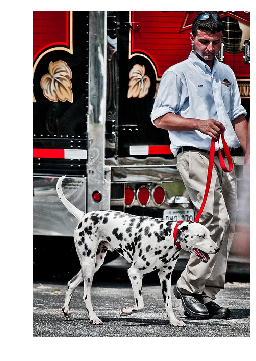

In [9]:
# Show sample data set by choosing categories
temp_cat = ['dog', 'person', 'ball']

catIds = coco.getCatIds(catNms=temp_cat)
imgIds = coco.getImgIds(catIds=catIds)

# Identify relevant images
if len(imgIds) > 0:
    imgIds = coco.getImgIds(imgIds=imgIds[-1])  # Pick the last image
    print("The index of the chosen image is %s.\n" % (str(imgIds[0])))
else:
    print("No matched images found.")

# Load and display captions
annIds = coco_caps.getAnnIds(imgIds)
anns = coco_caps.loadAnns(annIds)
print("The corresponding captions are:")
coco_caps.showAnns(anns)

# Show image
img = coco.loadImgs(imgIds)[0]
I = io.imread('%s/%s/%s' % (data_dir, data_type, img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

### Train-test Split

Captions, images paths, and encoded image features are needed in order to effectively implemented the training. Rather than using `train_test_split` function, I choose to shuffle the data and subset to obtain a 80/20 split of train and validation data.

In [10]:
# Specify total number of samples to be used for training and testing.
total_examples = 100000
train_examples = int(0.8 * total_examples)

# Subset training and testing images
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_img_path_vector = {}
all_img_name_vector = list(set([x['image_id'] for x in annotations['annotations']]))
print(
    "Choosing %s training images and %s validation images from a total of %s images"
    % (train_examples, total_examples - train_examples, len(all_img_name_vector)))

for img_id in all_img_name_vector:
    img = coco.loadImgs(img_id)[0]
    image_file_path = '%s/%s/%s' % (data_dir, data_type, img['file_name'])
    all_img_path_vector[img_id] = image_file_path

# Shuffle and obtain subset
all_img_name_vector = sklearn.utils.shuffle(all_img_name_vector, random_state=0)
all_img_name_vector = all_img_name_vector[:total_examples]

# Obtain train and test set
train_img_name_vector = all_img_name_vector[:train_examples]  # train
test_img_name_vector = all_img_name_vector[train_examples:]  # test

Choosing 80000 training images and 20000 validation images from a total of 118287 images


## Image Embeddings

I use a pre-trained model, Inception-V3 model, to encode images such that we obtained the feature vectors of the image. I took out the final fully-connected layer in order to pass the features along to the image captioning model. When encoding, note that hash table is used to ensure I am encoding distinct images. This is because one image has multiple captions associated with it.

In [11]:
# Create the inception v3 model
# take out the fully connected layers at the end to have it output image embeddings
image_model = keras.applications.InceptionV3(weights='imagenet')
feature_model = keras.models.Model(image_model.input,
                                   image_model.layers[-2].output)

W0803 00:42:30.570591 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 00:42:30.643588 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0803 00:42:30.897742 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0803 00:42:31.494488 139980666660736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



96116736/96112376 [==============================] - 1s 0us/step


Define encoding function that:
* Transform the image into consistent sizes
* Convert the images to array
* Expand dimensions
* Pre-process the input
* Reshape images

In [0]:
# Encoding function for feature extraction
def encode(image_path):
    # Preprocess images
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    
    # Produce image embeddings
    fea_vec = feature_model.predict(img_array)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1])
    return (fea_vec)

In [0]:
# Similar function for testing how inception v3 model works
def inceptionv3_predict(image_path, image_model):
    # Preprocess images
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(299, 299))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    preds = image_model.predict(img_array)
    P = keras.applications.imagenet_utils.decode_predictions(preds)

    # Show prediction result
    for (i, (imagenetID, label, prob)) in enumerate(P[0]):
        print("{}. {}: {:.2f}%".format(i + 1, label, prob * 100))

    # Show image
    I = io.imread(image_path)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

The Inception V3 model is able to recognize objects in a given image. 

40960/35363 [==================================] - 0s 0us/step
1. trailer_truck: 65.54%
2. tow_truck: 6.49%
3. snowplow: 5.56%
4. harvester: 5.50%
5. crane: 1.44%


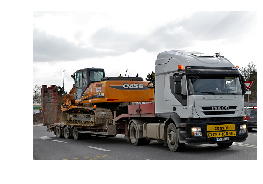

In [14]:
# Randomly choose images to be predicted by Inception V3
random_img_id = np.random.choice(all_img_name_vector)
random_img_path = all_img_path_vector[random_img_id]
inceptionv3_predict(random_img_path, image_model)

Encode images and then store the encoded image features in a pickle file to be loaded for future uses. The following code takes around 2100 seconds on the Titan Xp GPU. Please only run the code once to store the results.

In [15]:
# Encode all the train images. Run once and store features in a pickle file
start = time()
train_features = {}
for img_id in all_img_name_vector:
    train_features[img_id] = encode(all_img_path_vector[img_id])

# Took around 2100 seconds.
print("Time taken in seconds =", time() - start)

# Pickle the features
with open(data_dir + "/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(train_features, encoded_pickle)

Time taken in seconds = 2274.08997130394


In [16]:
# Load image features from the pickle file
train_features = pickle.load(open(data_dir + "/encoded_train_images.pkl", "rb"))
print('%d photos in total are encoded. These include both training and testing image set.' 
      % len(train_features))

100000 photos in total are encoded. These include both training and testing image set.


For each captions in the training and testing data set, I append images back onto the captions so that all captions and features are included.

In [0]:
# Create the train image data set
captions = []
images = []
images_features = []

for img_id in train_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))

    for caption in [x['caption'] for x in img_captions]:
        captions.append('start_sentence ' + caption + ' end_sentence')
        images.append(img_path)
        images_features.append(img_feature)

captions, images, images_features = sklearn.utils.shuffle(captions,
                                                          images,
                                                          images_features,
                                                          random_state=0)

In [0]:
# Create the validation image data set
test_captions = []
test_images = []
test_images_features = []

for img_id in test_img_name_vector:
    img_path = all_img_path_vector[img_id]
    img_feature = train_features[img_id]
    img_captions = coco_caps.loadAnns(coco_caps.getAnnIds(img_id))

    for caption in [x['caption'] for x in img_captions]:
        test_captions.append('start_sentence ' + caption + ' end_sentence')
        test_images.append(img_path)
        test_images_features.append(img_feature)

test_captions, test_images, test_images_features = sklearn.utils.shuffle(
    test_captions, test_images, test_images_features, random_state=0)

In [19]:
print('Training: %s distinct images, %s captions,' %
      (len(list(set(images))), len(captions)))
print('Validation: %s distinct images, %s captions.' %
      (len(list(set(test_images))), len(test_captions)))

Training: 80000 distinct images, 400219 captions,
Validation: 20000 distinct images, 100048 captions.


## Word Embeddings

Similarly, we use word embeddings to transform the words in captions into vectors. We start by tokenizing the vocabulary and understanding the distribution of sentence lengths in the caption data set.

In [0]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
number_of_words = 6000

# Choose the top words from the vocabulary
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=number_of_words,
    oov_token="<unk>",
    filters='!"#$%&()*+.,-/:;=?@[\]^`{|}~ ')
captions = [caption.lower() for caption in captions]
tokenizer.fit_on_texts(captions)

In [0]:
# Index the padding values
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

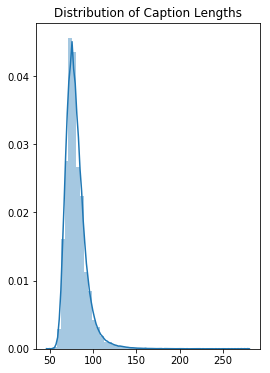

In [23]:
# Understand the distribution of sentence lengths
sentence_lengths = [len(caption) for caption in captions]
plt.title('Distribution of Caption Lengths')
sns.distplot(sentence_lengths)

Global Vectors for Word Representation (GloVe) are then used to obtain embedding vectors for words in the captions. Pre-trained embedding is used to save time and ensure accuracy.

In [24]:
# Calculates sentence and vocab lengths
# Manually set the maximum sentence length after observing the distribution
max_length = 100  
vocab_size = len(tokenizer.index_word)
print("Original max sentence length is %s; I set it to %s." %
      (calc_max_length(captions), max_length))
print("The vocabulary size is: %s" % (vocab_size))

Original max sentence length is 278; I set it to 100.
The vocabulary size is: 23705


The `glove.6B.300d.txt` file obtaiend at the beginning of the notebook is used here. 

In [25]:
embedding_dim = 300
embeddings_index = {}

with open(data_dir + '/glove6b/glove.6B.%sd.txt' % (embedding_dim),
          encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
# Get dense vector
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in (tokenizer.word_index).items():
    # All 0 is words not found in the embedding index
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
embedding_matrix.shape

(23705, 300)

## Model

The original model framework used here is inspired by various online blog posts and tutorials on similar projects. The use of Inception V3 and for image encoding is inspired by the paper [Show, Attend and Tell: Neural Image Caption
Generation with Visual Attention](https://arxiv.org/pdf/1502.03044.pdf).

In [28]:
# Extract features
inputs1 = tf.keras.Input(shape=(2048, ))
fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
# Sequence model
inputs2 = tf.keras.Input(shape=(max_length, ))
se1 = tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                mask_zero=True)(inputs2)
se2 = tf.keras.layers.Dropout(0.5)(se1)
se3 = tf.keras.layers.LSTM(256)(se2)
# Decoder model
decoder1 = tf.keras.layers.Add()([fe2, se3])
decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
# Final model
model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)

W0803 01:21:28.614344 139980666660736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 01:21:28.639650 139980666660736 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0803 01:21:28.881483 139980666660736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.pytho

Set weight using the glove embedding matrix

In [0]:
# Add the embedding matrix and set the layer to be not trainable
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     7111500     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

### Training

This function is used to generate a sequence of text as input and output. The generated sequences are then past into data generator and used for caption predictions. The `generate_sequences` function allows the model to perform word-by-word caption generation.

In [0]:
# Generate sentence to break sentence into in and out segments for word-by-word prediction
def generate_sequences(tokenizer, max_length, caption, image_feature):
    Ximages, XSeq, y = list(), list(), list()
    vocab_size = len(tokenizer.word_index)
    seq = tokenizer.texts_to_sequences([caption])[0]
    # Split one sequence into multiple X,y pairs
    for i in range(1, len(seq)):
        # Select substrings
        in_seq, out_seq = seq[:i], seq[i]
        # Pad input sequence
        in_seq = tf.keras.preprocessing.sequence.pad_sequences(
            [in_seq], maxlen=max_length, padding='post')[0]
        # Encode output sequence
        out_seq = tf.keras.utils.to_categorical([out_seq],
                                                num_classes=vocab_size)[0]

        image_feature = np.squeeze(image_feature)
        Ximages.append(image_feature)
        XSeq.append(in_seq)
        y.append(out_seq)
        
    # Connect sentence sequence with images and the output sequence
    Ximages, XSeq, y = np.array(Ximages), np.array(XSeq), np.array(y)
    return [Ximages, XSeq, y]

Create Python data generator object to loop through all images. Use batch size to batch images and their corresponding caption sequences together before `yielding` to the `fit generator`.

In [0]:
# Python data generator object to loop through all images
def data_generator(tokenizer, max_length, captions, images_features, batch_size):
    n = 0
    while True:
        for i in range(len(captions)):
            in_img_vector = []
            in_seq_vector = []
            out_word_vector = []
            # Load image feature
            image_feature = images_features[i]
            # Generate word sequence
            caption = captions[i]
            in_img, in_seq, out_word = generate_sequences(
                tokenizer, max_length, caption, image_feature)
            in_img_vector.append(in_img)
            in_seq_vector.append(in_seq)
            out_word_vector.append(out_word)
            n += 1
            # When batch size is reached, yield the output
            if n == batch_size:
                n = 0
                yield [in_img, in_seq], out_word

In [0]:
# Predict caption
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'start_sentence'
    for i in range(max_length):
        # Use input and image to start predict the rest of the caption
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = tf.keras.preprocessing.sequence.pad_sequences(
            [sequence], maxlen=max_length, padding='post')
        photo = photo.reshape(2048, 1).T
        
        # Predict the next word based on sequence and image
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        
        # End prediction when no word is predicted or if ending word is seen
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end_sentence':
            break
    
    # Remove beginning and ending signal words when output
    in_text = re.sub(r'(start|end)_sentence', '', in_text).strip()
    return in_text

In [0]:
# Store default weights in the model directory
model_directory = './model'

if not os.path.exists(model_directory):
    os.makedirs(model_directory)

model.save_weights(model_directory + '/model.h5')

Reset model weights to default

In [0]:
# Reset model with default weights before training
model.load_weights(model_directory + '/model.h5')

I used a fit generator because it is difficult to store $10,000$ images in the memory.

In [0]:
# Specify final model parameters
# After trying out different batch sizes, chose the one that provided the most reasonable results
epochs = 50
batch_size = 500
steps = len(captions) // batch_size
epoch_idx = 0

In [0]:
# Create dictionary to store loss values. Need this because using fit generator
loss = {}

In [0]:
# Use fit generator due to limited memory.
while epoch_idx <= epochs:
    # Use data generator to input data
    generator = data_generator(tokenizer, max_length, captions,
                               images_features, batch_size)
    # Fit generator is used due to memory limitation
    history = model.fit_generator(generator, steps_per_epoch=steps, verbose=1)
    loss[epoch_idx] = history.history['loss']
    model.save_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epoch_idx, batch_size))

    epoch_idx += 1

    # Keep track of the number of distinct captions
    distinct_desc = []
    temp_desc = ''
    for j in range(20):
        img_desc = generate_desc(model, tokenizer, images_features[j], max_length)
        distinct_desc.append(img_desc)
        temp_desc += '' + img_desc

    print("Model %s generated %s distinct captions with %s distinct words." %
          (epoch_idx, len(list(set(distinct_desc))), len(list(set(temp_desc.split(' '))))))

784/800 [============================>.] - ETA: 9s - loss: 5.7704

At the first few epochs of the model training process, the model exhibits underfitting behavior where no distinct captions are generated. By understanding the number of distinct captions generated for a list of 20 images, I seek to approximate the appeal the model has for a human reader. In addition, as a model continues to learn from the training data, it becomes capable of generating more vocabularies as well.

In [0]:
# Return the loss plot
plt.title('Model Training Loss')

loss_lists = sorted(loss.items())
x, y = zip(*loss_lists)
plt.plot(x, y)

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
# Train images
print(
    "Sample prediction of the model with a batch size of %s and %s epochs.\n" %
    (batch_size, epochs))

# Load the latest model weight
model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                   (epochs, batch_size))

# Output prediction for the first five images in the validation data. 
# Note that the data set is already shuffled.
np.random.seed(0)
for j in np.random.choice(range(len(test_captions)), 5):
    # Compare captions
    img_desc = generate_desc(model, tokenizer, test_images_features[j],
                             max_length)
    actual_caption = test_captions[j]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)

    print("Predicted Caption: %s \nActual Caption: %s" %
          (img_desc, actual_caption))
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s" % (result_bleu))
    # Show image
    I = io.imread(test_images[j])
    plt.imshow(I)
    plt.axis('off')
    plt.show()

### Tuning

A wide range of parameters in the model can be tuned. Due to the limited computation resources and methods for tuning with fit generator, I tuned the batch size. If I have more time, I will also tune the drop out rate, maximum sentence length, word frequency cut-off values (currently none), etc.

In [0]:
# Trying out different batch sizes
for batch_size in [500, 1000, 2000, 3000]:
    loss = {}
    model.load_weights(model_directory + '/model.h5')
    steps = len(captions) // batch_size
    print(batch_size)
    epoch_idx = 0
    while epoch_idx <= epochs:
        generator = data_generator(tokenizer, max_length, captions,
                                   images_features, batch_size)
        history = model.fit_generator(generator,
                                      steps_per_epoch=steps,
                                      verbose=1)
        loss[epoch_idx] = history.history['loss']

        model.save_weights(model_directory + '/model_epoch' + str(epoch_idx) +
                           "_bs" + str(batch_size) + '.h5')
        epoch_idx += 1

        distinct_desc = []
        temp_desc = ''
        for j in range(20):
            img_desc = generate_desc(model, tokenizer, images_features[j],
                                     max_length)
            distinct_desc.append(img_desc)
            temp_desc += '' + img_desc

        print("%s distinct captions, %s distinct words." % (len(
            list(set(distinct_desc))), len(list(set(temp_desc.split(' '))))))

    # Plot model loss
    plt.title('Model Training Loss')

    loss_lists = sorted(
        loss.items())  # sorted by key, return a list of tuples
    x, y = zip(*loss_lists)  # unpack a list of pairs into two tuples
    plt.plot(x, y)

    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

Now, we turn to test the performance of the models trained using different batch sizes using the same train and validation images.

#### Test on Training Data

In [0]:
np.random.seed(47)

In [0]:
rand_train_image = np.random.choice(range(len(captions)))

In [0]:
I = io.imread(images[rand_train_image])
plt.imshow(I)
plt.axis('off')
plt.show()

# Obtain actual and predicted images and their captions
actual_caption = captions[rand_train_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:" %
      (actual_caption))

for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer,
                             images_features[rand_train_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s" % (bs, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s\n" % (result_bleu))

#### Test on Validation Data

In [0]:
np.random.seed(47)

In [0]:
rand_test_image = np.random.choice(range(len(test_captions)))

In [0]:
I = io.imread(images[rand_test_image])
plt.imshow(I)
plt.axis('off')
plt.show()

# Obtain actual and predicted images and their captions
actual_caption = captions[rand_test_image]
actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()
print("The actual caption is:\n%s \n\nThe predicted captions are:" %
      (actual_caption))

for bs in [500, 1000, 2000, 3000]:
    model.load_weights(model_directory + '/model_epoch%s_bs%s.h5' %
                       (epochs - 1, bs))
    # Compare captions
    img_desc = generate_desc(model, tokenizer,
                             images_features[rand_test_image], max_length)

    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption)
    print("Batch size = %s: %s" % (bs, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("Resulting BLEU-4 score is %s\n" % (result_bleu))

## Discussion

In [0]:
# Understand vocab distribution to showcase the model bias
# Note that identifying stop words and lemmatization takes a while.
word_list = []
for caption in captions:
    seq = caption.split(" ")
    word_list += seq

# Remove idiosyncracies in word usage
lemmatizer = WordNetLemmatizer()
word_list = [
    lemmatizer.lemmatize(word.lower()) for word in word_list
    if word and word.lower() not in nltk.corpus.stopwords.words('english')
    and "_" not in word
]

# Calculate frequency distribution
word_list_dist = nltk.FreqDist(word_list)

In [0]:
# Run this line to output most frequently used vocabularies in the data set
limit = 30
word_dict = dict()
for word, frequency in word_list_dist.most_common(limit):
    print(u'{}\t\t{}'.format(word, frequency))
    word_dict[word] = frequency

### Results & Learning

Image captioning requires implementation of deep learning methods in both computer vision and natural language processing. While doing this project, I learned to use image and word embeddings to map them into vector representations to be supplied for training. Drop-out layers are included to prevent the model from overfitting, and model tuning is performed to ensure the model achieve reasonable performance. 

Tuning helped identified that the model tends to perform better with larger batch sizes among the list of the values tested. Increasing the number of epochs is shown to help the model generate more complex vocabularies, but doing that also cause the model to overfit easily. The final model is able to produce sensible captions for the images supplied. However, there remains potential for improvements. 


### Areas of Improvement

The model is able to provide reasonable captions given the images supplied. However, there remain potential for improvements. The model appears to have difficulty distinguish objects with similar property, and the model also has a bias towards objects and captions that appear more often in the data set.

The model seems to have trouble distinguishing between objects that have subtle differences, such as sky and ocean, snowboards and surf board, etc. For instance, the model mistakes a man performing a snowboard jump as someone surfing in the ocean, presumably because the blue sky in the background bears resemblance to the color ocean, and the skis appearing in the image looks similar to a surf board. Data augmentation using data generators in the less popular objects can be applied in order to improve model accuracy on the less popular objects. 

Furthermore, there also appear to be bias in captioning due to the nature of the caption data provided. When describing people in images, the model is more likely to predict a person as a "man" even when the subject is in fact a woman. This is likely caused by the nature of the original training captions. As an evidence, in the "Word Distribution" section, you will notice that the "man" is the most popular word used after removing stop words, while women is ranked 5th. Here is the short list of words with their respective frequencies in the data set together with an example of the prediction that shows the model's gender bias. 

```
man        48873
sitting    35724
two        32401
standing   28438
people     27452
woman      26082
```

In this example, the model confuses man and woman. As shown in the list above, "man" is the more popular word.

In [0]:
def show_img_example(img_idx):
    # Show images given index
    I = io.imread(images[img_idx])
    plt.imshow(I)
    plt.axis('off')
    plt.show()

    # Create actual and predicted caption
    actual_caption = captions[img_idx]
    actual_caption = re.sub(r'(start|end)_sentence', '', actual_caption).strip()

    model.load_weights(model_directory + '/model_epoch50_bs500.h5')
    img_desc = generate_desc(model, tokenizer, images_features[img_idx],
                             max_length)

    print("The actual caption is:\n%s \n\nThe predicted captions is:\n%s" %
          (actual_caption, img_desc))
    
    result_bleu = nltk.translate.bleu_score.sentence_bleu(
        actual_caption, img_desc)
    print("\nResulting BLEU-4 score is %s\n" % (result_bleu))

In [0]:
show_img_example(3912)

In this example, the model confuses child and per. As shown in the list above, "people" or person is the more popular word.

In [0]:
show_img_example(56894)

On the other hand, "baseball" is a popular term, and we can see fairly good prediction of images related to baseballs. 

In [0]:
show_img_example(88870)

Skateboard is another popular category of images with fairly good prediction.

In [0]:
show_img_example(77279)

One future improvement is to upsample the female images and captions in the data set to improve the model's ability to recognize female. In addition, in the process of image labeling, the generic use of "man" when both genders appear should be avoided to help model better understand the gender differences. 

The categorical loss measure for model accuracy is not a good measure of the model performance. While the model performance improves with categorical accuracy, at a low loss value, the model has tendency of overfitting, producing vocabularies that do not fit well together as a sentence. In summary, the loss metric measures categorical accuracy of the word prediction, but it fails to account for the readability of the content. I have tested out the use of BLEU score to measure sentence similarity, but it fails to account for the semantic similarity of the predicted caption and actual caption. In addition, due to the difficulty with the caption learning task in itself, the scale BLEU score provides fails to provide meaningful comparison across models. For instance, one might argue that the predicted caption in the following example "a baby giraffe eating leaves on a meadow" is a good approximation of the original one "A giraffe that is eating some leaves off of a tree". However, a BLEU score of $1.39e^{-231}$ is given.

In [0]:
result_bleu = nltk.translate.bleu_score.sentence_bleu(
    "A giraffe that is eating some leaves off of a tree.",
    "a baby giraffe eating leaves on a meadow ")
print("Resulting BLEU-4 score is %s" % (result_bleu))

Lastly, I was unable to identify a way to perform grid search for hyper-parameter tuning when `fit_generator` is used. In addition, my computation resource is limited. Therefore, I used a `for` loops for testing the model with different batch sizes. If time and resource permit, I will also tune drop out rate, maximum sentence length, word frequency cut-off values (currently none), etc.

-----

Random image generator to help me find examples:

In [0]:
img_idx = np.random.choice(range(len(test_captions)))
show_img_example(img_idx)
print(img_idx)

----

Link to Youtube Video: <mark>link</mark>